<center> <h1>Double-Pendulum</h1> </center>

<h2>Summary</h2>

This notebook is meant as a simple example of how to solve problems in python and produce results. Here you can learn:

- Solving systems of ODEs
- Plotting results

<h2>Packages</h2>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.widgets import Button
from IPython import display
%matplotlib inline
# produce the plot inside notebook
matplotlib.rc(r'xtick', labelsize=25) 
matplotlib.rc(r'ytick', labelsize=25) 
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 35}
matplotlib.rc('font', **font)
plt.rcParams['xtick.major.pad']='8'
plt.rcParams['ytick.major.pad']='8'

In [2]:
display.Image(url='http://scienceworld.wolfram.com/physics/dimg270.gif')

<h2>Plotting the IC</h2>

In [3]:
class DraggablePoint:
    lock = None #only one can be animated at a time
    def __init__(self, point):
        self.point = point
        self.press = None
        self.background = None

    def connect(self):
        self.cidpress = self.point.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = self.point.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.point.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        if event.inaxes != self.point.axes: return
        if DraggablePoint.lock is not None: return
        contains, attrd = self.point.contains(event)
        if not contains: return
        self.press = (self.point.center), event.xdata, event.ydata
        DraggablePoint.lock = self

        # draw everything but the selected rectangle and store the pixel buffer
        canvas = self.point.figure.canvas
        axes = self.point.axes
        self.point.set_animated(True)
        canvas.draw()
        self.background = canvas.copy_from_bbox(self.point.axes.bbox)

        # now redraw just the rectangle
        axes.draw_artist(self.point)

        # and blit just the redrawn area
        canvas.blit(axes.bbox)

    def on_motion(self, event):
        if DraggablePoint.lock is not self:
            return
        if event.inaxes != self.point.axes: return
        self.point.center, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        self.point.center = (self.point.center[0]+dx, self.point.center[1]+dy)

        canvas = self.point.figure.canvas
        axes = self.point.axes
        # restore the background region
        canvas.restore_region(self.background)

        # redraw just the current rectangle
        axes.draw_artist(self.point)

        # blit just the redrawn area
        canvas.blit(axes.bbox)

    def on_release(self, event):
        if DraggablePoint.lock is not self:
            return

        self.press = None
        DraggablePoint.lock = None

        # turn off the rect animation property and reset the background
        self.point.set_animated(False)
        self.background = None

        # redraw the full figure
        self.point.figure.canvas.draw()

    def disconnect(self):
        self.point.figure.canvas.mpl_disconnect(self.cidpress)
        self.point.figure.canvas.mpl_disconnect(self.cidrelease)
        self.point.figure.canvas.mpl_disconnect(self.cidmotion)

<IPython.core.display.Javascript object>


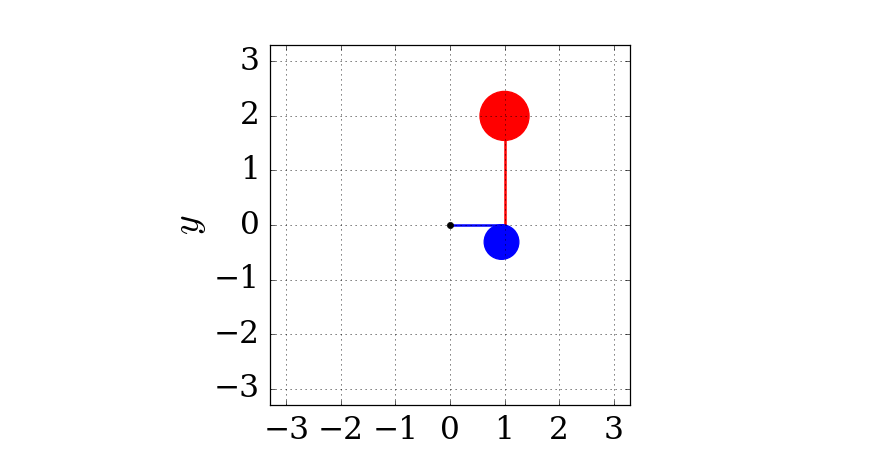

In [7]:
%matplotlib notebook

m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 2.0
L = l1 + l2
g = 9.81

i = 0

the1 = [90*np.pi/180] # radians
pthe1 = [0]

the2 = [180*np.pi/180] # degrees
pthe2 = [0]

x1 = [0, l1 * np.sin(the1[i])]
y1 = [0, -l1 * np.cos(the1[i])]
x2 = [x1[1], x1[1] + l2 * np.sin(the2[i])]
y2 = [y1[1], y1[1] - l2 * np.cos(the2[i])]

fig01 = plt.figure(1, figsize=(10, 5), dpi=90)
ax01 = fig01.add_subplot(1, 1, 1)
ax01.axis('square')
ax01.axis([-1.1*L, 1.1*L, -1.1*L, 1.1*L])
center = ax01.plot(0, 0, '.k')
link1 = ax01.plot(x1, y1, '-b', zorder=1)
link2 = ax01.plot(x2, y2, '-r', zorder=1)
plt.setp(center, ms=10.0)
plt.setp(link1, lw=2.0)
plt.setp(link2, lw=2.0)

ax01.grid('on')
ax01.set_xlabel(r'$x$', fontsize=30.0)
ax01.set_ylabel(r'$y$', fontsize=30.0)

mass1 = plt.Circle((x1[1],y1[1]), np.sqrt(m1)/np.pi, color='b')
mass2 = plt.Circle((x2[1],y2[1]), np.sqrt(m2)/np.pi, color='r')
mass1.set_zorder(2)
mass2.set_zorder(2)
ax01.add_patch(mass1)
ax01.add_patch(mass2)
dm1 = DraggablePoint(mass1)
dm1.connect()
dm2 = DraggablePoint(mass2)
dm2.connect()

plt.show()

<h2> Solving the ODE </h2>

The equations of motion are found by calculating the Hamiltonian and taking its' derivatives (see [here](http://scienceworld.wolfram.com/physics/DoublePendulum.html)):

\begin{equation}
\begin{split}
\dot{\theta}_1 & = \frac{l_2 p_{\theta_1} - l_1 p_{\theta_2} cos(\theta_1 - \theta_2)}{l^2_1 l_2 [m_1 + m_2 sin^2(\theta_1 - \theta_2)]}\\
\dot{\theta}_2 & = \frac{l_1 (m_1 + m_2) p_{\theta_2} - l_2 m_2 p_{\theta_1} cos(\theta_1 - \theta_2)}{l_1 l^2_2 [m_1 + m_2 sin^2(\theta_1 - \theta_2)]}\\
\dot{p}_{\theta_1} & = -(m_1 + m_2) g l_1 sin \theta_1 - C_1 + C_2\\
\dot{p}_{\theta_2} & = -m_2 g l_2 sin \theta_2 + C_1 - C_2
\end{split}
\end{equation}

where

\begin{equation}
\begin{split}
C_1 & = \frac{p_{\theta_1} p_{\theta_2} sin(\theta_1 - \theta_2)}{l_1 l_2 [m_1 + m_2 sin^2(\theta_1 - \theta_2)]}\\
C_2 & = \frac{l^2_2 m_2 p^2_{\theta_1} + l^2_1 (m_1 + m_2) p^2_{\theta_2} - l_1 l_2 m_2 p_{\theta_1} p_{\theta_2} cos(\theta_1 - \theta_2)}{2 l^2_1 l^2_2 [m_1 + m_2 sin^2(\theta_1 - \theta_2)]^2} sin[2(\theta_1 - \theta_2)]
\end{split}
\end{equation}

<h3> Runge Kutta Method </h3>

Steps:

0) Define a step size $ h > 0 $

1) Calculate each differential equation at the current time step:

\begin{equation}
\begin{split}
k_1 & = f(t_n, y_n)\\
k_2 & = f(t_n + \frac{h}{2}, y_n + \frac{h}{2} k_1)\\
k_3 & = f(t_n + \frac{h}{2}, y_n + \frac{h}{2} k_2)\\
k_4 & = f(t_n + h, y_n + h k_3)
\end{split}
\end{equation}

2) Calculate the next value for each variable using the "slope" calculated as:

\begin{equation}
\begin{split}
y_{n + 1} = y_n + \frac{h}{6} (k_1 + 2 k_2 + 2 k_3 + k_4)\\
t_{n + 1} = t_n + h
\end{split}
\end{equation}

3) Repeat steps 1-2 for until the desired time step has been reached.

In [4]:
def dthe1(m1, m2, l1, l2, g, the1, the2, pthe1, pthe2):
    return (l2*pthe1 - l1*pthe2*np.cos(the1 - the2))/ \
        (l1**2*l2*(m1 + m2*np.sin(the1 - the2)**2))

def dthe2(m1, m2, l1, l2, g, the1, the2, pthe1, pthe2):
    return (l1*(m1 + m2)*pthe2 - l2*m2*pthe1*np.cos(the1 - the2))/ \
        (l1*l2**2*m2*(m1 + m2*np.sin(the1 - the2)**2))

def dpthe1(m1, m2, l1, l2, g, the1, the2, pthe1, pthe2):
    C1 = (pthe1*pthe2*np.sin(the1 - the2))/ \
        (l1*l2*(m1 + m2*np.sin(the1 - the2)**2))
    
    C2 = (l2**2*m2*pthe1**2 + l1**2*(m1 + m2)*pthe2**2 - \
        l1*l2*m2*pthe1*pthe2*np.cos(the1 - the2))/ \
        (2*l1**2*l2**2*(m1 + m2*np.sin(the1 - the2)**2)**2)* \
        np.sin(2*(the1 - the2))
    
    return -(m1 + m2)*g*l1*np.sin(the1) - C1 + C2

def dpthe2(m1, m2, l1, l2, g, the1, the2, pthe1, pthe2):
    C1 = (pthe1*pthe2*np.sin(the1 - the2))/ \
        (l1*l2*(m1 + m2*np.sin(the1 - the2)**2))
    
    C2 = (l2**2*m2*pthe1**2 + l1**2*(m1 + m2)*pthe2**2 - \
        l1*l2*m2*pthe1*pthe2*np.cos(the1 - the2))/ \
        (2*l1**2*l2**2*(m1 + m2*np.sin(the1 - the2)**2)**2)* \
        np.sin(2*(the1 - the2))
    
    return -m2*g*l2*np.sin(the2) + C1 - C2

In [5]:
h = 0.01
check = 0
i = 0
while check == 0:
    k1_the1 = dthe1(m1, m2, l1, l2, g, the1[i], the2[i], pthe1[i], pthe2[i])
    k1_the2 = dthe2(m1, m2, l1, l2, g, the1[i], the2[i], pthe1[i], pthe2[i])
    k1_pthe1 = dpthe1(m1, m2, l1, l2, g, the1[i], the2[i], pthe1[i], pthe2[i])
    k1_pthe2 = dpthe2(m1, m2, l1, l2, g, the1[i], the2[i], pthe1[i], pthe2[i])
    
    k2_the1 = dthe1(m1, m2, l1, l2, g, the1[i] + h/2*k1_the1, the2[i] + h/2*k1_the2, pthe1[i] + h/2*k1_pthe1, pthe2[i] + h/2*k1_pthe2)
    k2_the2 = dthe2(m1, m2, l1, l2, g, the1[i] + h/2*k1_the1, the2[i] + h/2*k1_the2, pthe1[i] + h/2*k1_pthe1, pthe2[i] + h/2*k1_pthe2)
    k2_pthe1 = dpthe1(m1, m2, l1, l2, g, the1[i] + h/2*k1_the1, the2[i] + h/2*k1_the2, pthe1[i] + h/2*k1_pthe1, pthe2[i] + h/2*k1_pthe2)
    k2_pthe2 = dpthe2(m1, m2, l1, l2, g, the1[i] + h/2*k1_the1, the2[i] + h/2*k1_the2, pthe1[i] + h/2*k1_pthe1, pthe2[i] + h/2*k1_pthe2)
    
    k3_the1 = dthe1(m1, m2, l1, l2, g, the1[i] + h/2*k2_the1, the2[i] + h/2*k2_the2, pthe1[i] + h/2*k2_pthe1, pthe2[i] + h/2*k2_pthe2)
    k3_the2 = dthe2(m1, m2, l1, l2, g, the1[i] + h/2*k2_the1, the2[i] + h/2*k2_the2, pthe1[i] + h/2*k2_pthe1, pthe2[i] + h/2*k2_pthe2)
    k3_pthe1 = dpthe1(m1, m2, l1, l2, g, the1[i] + h/2*k2_the1, the2[i] + h/2*k2_the2, pthe1[i] + h/2*k2_pthe1, pthe2[i] + h/2*k2_pthe2)
    k3_pthe2 = dpthe2(m1, m2, l1, l2, g, the1[i] + h/2*k2_the1, the2[i] + h/2*k2_the2, pthe1[i] + h/2*k2_pthe1, pthe2[i] + h/2*k2_pthe2)
    
    k4_the1 = dthe1(m1, m2, l1, l2, g, the1[i] + h*k3_the1, the2[i] + h*k3_the2, pthe1[i] + h*k3_pthe1, pthe2[i] + h*k3_pthe2)
    k4_the2 = dthe2(m1, m2, l1, l2, g, the1[i] + h*k3_the1, the2[i] + h*k3_the2, pthe1[i] + h*k3_pthe1, pthe2[i] + h*k3_pthe2)
    k4_pthe1 = dpthe1(m1, m2, l1, l2, g, the1[i] + h*k3_the1, the2[i] + h*k3_the2, pthe1[i] + h*k3_pthe1, pthe2[i] + h*k3_pthe2)
    k4_pthe2 = dpthe2(m1, m2, l1, l2, g, the1[i] + h*k3_the1, the2[i] + h*k3_the2, pthe1[i] + h*k3_pthe1, pthe2[i] + h*k3_pthe2)
    
    the1.append(the1[i] + h/6*(k1_the1 + 2*k2_the1 + 2*k3_the1 + k4_the1))
    the2.append(the2[i] + h/6*(k1_the2 + 2*k2_the2 + 2*k3_the2 + k4_the2))
    pthe1.append(pthe1[i] + h/6*(k1_pthe1 + 2*k2_pthe1 + 2*k3_pthe1 + k4_pthe1))
    pthe2.append(pthe2[i] + h/6*(k1_pthe2 + 2*k2_pthe2 + 2*k3_pthe2 + k4_pthe2))
    
    x1 = [0, l1 * np.sin(the1[i])]
    y1 = [0, -l1 * np.cos(the1[i])]
    x2 = [x1[1], x1[1] + l2 * np.sin(the2[i])]
    y2 = [y1[1], y1[1] - l2 * np.cos(the2[i])]

    fig01 = plt.figure(1, figsize=(10, 5), dpi=90)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    ax01 = fig01.add_subplot(1, 1, 1)
    ax01.axis('square')
    ax01.axis([-1.1*L, 1.1*L, -1.1*L, 1.1*L])

    center = ax01.plot(0, 0, '.k')
    link1 = ax01.plot(x1, y1, '-b')
    link2 = ax01.plot(x2, y2, '-r')
    mass1 = ax01.plot(x1[1], y1[1], '.b')
    mass2 = ax01.plot(x2[1], y2[1], '.r')
    plt.setp(center, ms=10.0)
    plt.setp(link1, lw=2.0)
    plt.setp(link2, lw=2.0)
    plt.setp(mass1, ms=30.0 * (m1 ** 0.5))
    plt.setp(mass2, ms=30.0 * (m2 ** 0.5))
    ax01.grid('on')
    ax01.set_xlabel(r'$x$', fontsize=30.0)
    ax01.set_ylabel(r'$y$', fontsize=30.0)

    plt.show()
    
    i += 1
    if i == 1000:
        check = 1


KeyboardInterrupt: 

<h1> Updating the plot </h1>